In [1]:
# importing them
import pandas as pd
import numpy as np
from numba import cuda
import torch.cuda
from google.colab import runtime
import torch
import numpy as np
import pandas as pd
import io
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Preprocessing

In [2]:
dc = pd.read_excel('/content/DecOp_data_EN_500.xlsx',header = 0)

dc.head()



d1 = []
for i in range(dc.shape[0]):
  row = dc.iloc[i]
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['A'].replace('\n', " ") ,
  'labels'  : row['GT.A']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['E'].replace('\n', " ")  ,
  'labels'  : row['GT.E']})
  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['GM'].replace('\n', " ")  ,
  'labels'  : row['GT.GM']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['Pom'].replace('\n', " ")  ,
  'labels'  : row['GT.Pom']})

  d1.append({'ID': row['ID'],
      'age' :row['age'], 'gender': row['gender'],
  'sent' : row['CL'].replace('\n', " ")  ,
  'labels'  : row['GT.CL']})

decop = pd.DataFrame.from_records(d1)

decop=decop[['ID', 'sent', 'labels']]
decop['type']='A'


In [4]:
decop[:15]

,ID,sent,labels,type
0,1,Abortion should be banned! People are killing ...,F,A
1,1,I'm assuming we're talking about animals... eu...,T,A
2,1,I think gay marriage is just a normal as strai...,T,A
3,1,We need to keep them out of the country. They ...,F,A
4,1,I think it should be legalized and regulated l...,T,A
5,2,I believe in a woman's right to choose to abor...,F,A
6,2,I don't believe in taking one's own life. Only...,T,A
7,2,I am against gay marriage. The Bible is my gu...,T,A
8,2,We should allow all migrants in to this countr...,F,A
9,2,I am for cannabis legalization for medicinal p...,T,A


In [5]:
def create_dataset(Scenario={'train': [], 'test': [], 'scenario': 1}, decop=None, seed=42, cv=4):

    # generate training and testing set based on Scenario dictionary
    # cv number of cross-validation

    # initialize dictionaries to store train and test dataset for each split
    train = {f'split_{i + 1}': [] for i in range(cv)}
    test = {f'split_{i + 1}': [] for i in range(cv)}

    # generate shuffled indices for data splits
    np.random.seed(seed)

    de_arr = np.arange(1, 501)
    np.random.shuffle(de_arr)
    de_arr_r = de_arr.reshape((cv, int(500 / cv)))

    # generate train/test split
    # iterates over the splits and based on the scenario create train and test set.

    cv_ind = 0
    for k in train.keys():

        if Scenario['scenario'] == 1:

            if 'decop' in Scenario['train']:
                ind = de_arr_r[cv_ind, :]
                antind = [i for i in de_arr if i not in ind]

                decop_train = decop[decop['ID'].isin(antind)]
                decop_test = decop[decop['ID'].isin(ind)]

                train[k].append(decop_train)
                test[k].append(decop_test)

            train[k] = pd.concat(train[k])
            test[k] = pd.concat(test[k])

        cv_ind += 1

    return train, test


## GPT3.5 API


In [ ]:
!pip install datasets

In [7]:
from datasets import Dataset, load_metric
import json

# Code to prepare data in json format


In [8]:
DEFAULT_SYSTEM_PROMPT ='Given a statement, your task is to determine if the user is honest (T) or not (F) about their opinion.'

def create_jsonl(dataset: pd.DataFrame, file_name: str) -> None:
    with open(f'{file_name}.jsonl', 'w') as file:
        for row in dataset.itertuples():
            file.write(json.dumps({
                "messages": [{"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
                             {"role": "user", "content": row.sent},
                             {"role": "assistant", "content": row.labels}                             ]
                })+'\n')
    file.close()


In [9]:
from time import sleep

In [10]:
# Set seed for reproducibility.
# probaby this paart is not needed anymore
seed = (42)
np.random.seed(seed)
numcv = 4
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

# here I just tested how it works the split and how the json file looks like

for sp in tqdm(train.keys()):

    data_train = train[sp]
    data_test = test[sp]
    train_filename = f"training_scenario_{sp}"
    test_filename = f"testing_scenario_{sp}"
    create_jsonl(data_train, train_filename)
    create_jsonl(data_test, test_filename)
    sleep(10)
    print(f"training_scenario_{sp}: DONE")
    sleep(10)

  0%|          | 0/4 [00:00<?, ?it/s]

training_scenario_split_1: DONE
training_scenario_split_2: DONE
training_scenario_split_3: DONE
training_scenario_split_4: DONE


In [ ]:
# install openai

!pip install openai==0.28

In [12]:
import openai
from collections import defaultdict
import numpy as np
openai.api_key = ""

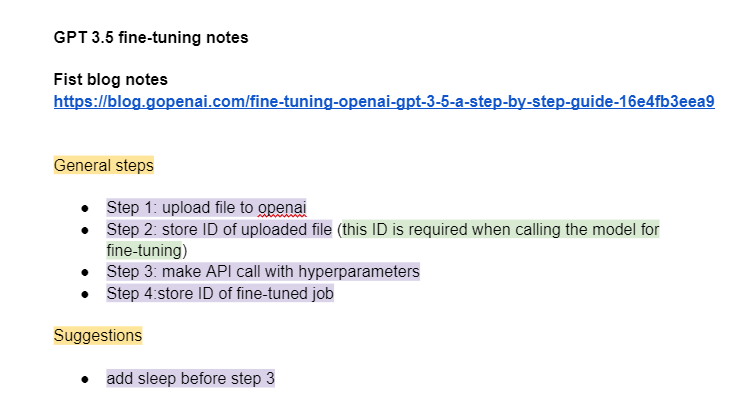


Related to my question this is how they do it! for them is validation and not test!!

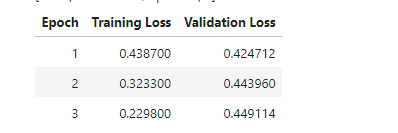

In [ ]:
seed = (42)
np.random.seed(seed)
numcv = 4
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

# here I just tested how it works the split and how the json file looks like

for sp in tqdm(train.keys()):

    data_train = train[sp]
    data_test = test[sp]

    create_jsonl(data_train, "training")
    create_jsonl(data_test, "testing")


    sleep(30)


    training_file = openai.File.create(
        file = open("training.jsonl","rb"),
         purpose = "fine-tune"
    )

    sleep(30)

    validation_file = openai.File.create(
        file = open("testing.jsonl","rb"),
         purpose = "fine-tune"
    )

    sleep(30)

    training_file_id = training_file.id # in one article is used training_file.id
    validation_file_id = validation_file.id

    sleep(30)

    # Doubt 1: here API want the validation file and not testing file as I'm using
    # May we use this?
    # IDEA: use only training file here and save
    # the response of testing file as they do in other tutorials
    # one of the models would cost less: gpt-3.5-turbo-1106 or gpt-3.5-turbo-0613
    # token limits: https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset
    # gpt-3.5-turbo-1106, the maximum context length is 16,385
    # gpt-3.5-turbo-0613
    fine_tuning_job = openai.FineTuningJob.create(
                                                 training_file = training_file_id,
                                                 validation_file = validation_file_id,
                                                 model="gpt-3.5-turbo",
                                                 hyperparameters={"n_epochs": 3}

                                                   )

    sleep(90)




In [ ]:
seed = (42)
np.random.seed(seed)
numcv = 4
dataset = ['decop']
Scenario = {'train': dataset, 'test': dataset, 'scenario': 1}
train, test = create_dataset(Scenario, decop=decop, seed=seed, cv=numcv)

# here I just tested how it works the split and how the json file looks like


training_file = openai.File.create(
      file = open("training_scenario_split_4.jsonl","rb"),
       purpose = "fine-tune"
    )

sleep(30)

validation_file = openai.File.create(
        file = open("testing_scenario_split_4.jsonl","rb"),
         purpose = "fine-tune"
    )

sleep(30)

training_file_id = training_file.id # in one article is used training_file.id
validation_file_id = validation_file.id

sleep(30)

    # Doubt 1: here API want the validation file and not testing file as I'm using
    # May we use this?
    # IDEA: use only training file here and save
    # the response of testing file as they do in other tutorials
    # one of the models would cost less: gpt-3.5-turbo-1106 or gpt-3.5-turbo-0613
    # token limits: https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset
    # gpt-3.5-turbo-1106, the maximum context length is 16,385
    # gpt-3.5-turbo-0613
fine_tuning_job = openai.FineTuningJob.create(
                                                 training_file = training_file_id,
                                                 validation_file = validation_file_id,
                                                 model="gpt-3.5-turbo",
                                                 hyperparameters={"n_epochs": 3}

                                                   )

sleep(90)

In [14]:
# list fine-tuning jobs
print(openai.FineTuningJob.list(limit=3))

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job",
      "id": "ftjob-0tIig869YfDbGawnA1znABWG",
      "model": "gpt-3.5-turbo-0613",
      "created_at": 1702827470,
      "finished_at": 1702831450,
      "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal::8WoXL9hZ",
      "organization_id": "org-jiAslREMw7COBkxjfjjyF4Ym",
      "result_files": [
        "file-kViAi717g45U68P4iDkPbXqY"
      ],
      "status": "succeeded",
      "validation_file": "file-ASAYE3JYu49AmJqTM6p08ihu",
      "training_file": "file-FBOMWQGi4xlywvsj9SA9uiND",
      "hyperparameters": {
        "n_epochs": 3,
        "batch_size": 3,
        "learning_rate_multiplier": 2
      },
      "trained_tokens": 595911,
      "error": null
    },
    {
      "object": "fine_tuning.job",
      "id": "ftjob-tMhoz5gfYuHogL259qg1P9MF",
      "model": "gpt-3.5-turbo-0613",
      "created_at": 1702827256,
      "finished_at": 1702831312,
      "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal::8WoV7

In [32]:
# this job started at 16:37
job_id_3cv = 'ftjob-0tIig869YfDbGawnA1znABWG'

# this job started at 16:34
job_id_2cv = 'ftjob-tMhoz5gfYuHogL259qg1P9MF'

# this job started at 16:30
job_id_1cv = 'ftjob-mYOiI8DUDY4NAAqXs4dKNxB9'

In [35]:
response_3cv  = openai.FineTuningJob.list_events(id=job_id_3cv, limit=10)
response_3cv

<OpenAIObject list at 0x7867faea8720> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-Lm9whs0MnTLVzpXmemY7w74w",
      "created_at": 1702831454,
      "level": "info",
      "message": "The job has successfully completed",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-yeY8EV61PZjZCkrHhYMrLoqT",
      "created_at": 1702831452,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:personal::8WoXL9hZ",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-jAMZ2YYWLTdnWEDf00Y0iP6E",
      "created_at": 1702831285,
      "level": "info",
      "message": "Step 1801/1875: training loss=0.00, validation loss=0.00",
      "data": {
        "step": 1801,
        "train_loss": 6.35782896551973e-07,
        "valid_loss": 6.357828776041666e-07,
        "train_mean_toke

https://community.openai.com/t/steps-meaning-in-fine-tuning-and-how-to-pick-the-optimal-number-of-epochs-from-them/390989/8

In [36]:
def extract_info_from_response(response):
    steps = []
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for event in response['data']:
        if 'data' in event and 'step' in event['data']:
            step_info = event['data']
            steps.append(step_info['step'])
            train_losses.append(step_info['train_loss'])
            valid_losses.append(step_info['valid_loss'])
            train_accs.append(step_info['train_mean_token_accuracy'])
            valid_accs.append(step_info['valid_mean_token_accuracy'])

    return steps, train_losses, valid_losses, train_accs, valid_accs

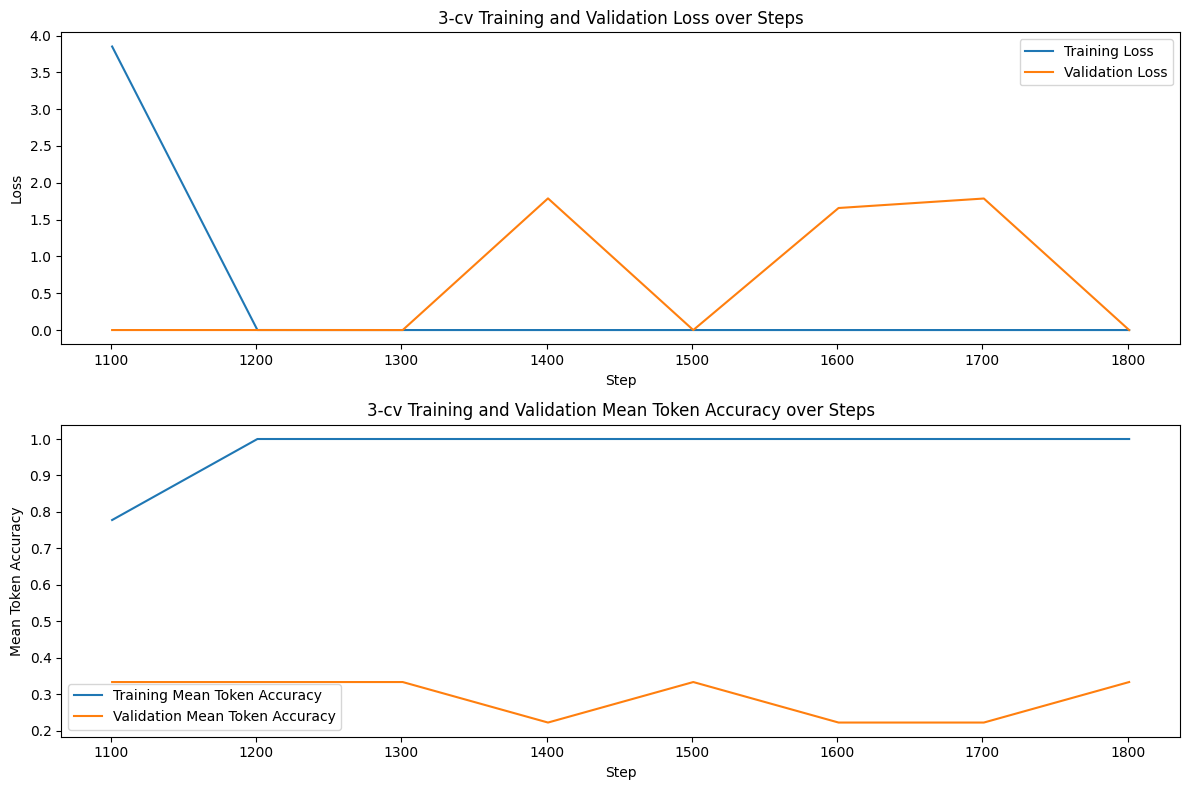

In [37]:
import matplotlib.pyplot as plt

# Extract information from the response
steps, train_losses, valid_losses, train_accs, valid_accs = extract_info_from_response(response_3cv)

# Create a line plot for Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(steps, train_losses, label='Training Loss')
plt.plot(steps, valid_losses, label='Validation Loss')
plt.title('3-cv Training and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Create a line plot for Mean Token Accuracy
plt.subplot(2, 1, 2)
plt.plot(steps, train_accs, label='Training Mean Token Accuracy')
plt.plot(steps, valid_accs, label='Validation Mean Token Accuracy')
plt.title('3-cv Training and Validation Mean Token Accuracy over Steps')
plt.xlabel('Step')
plt.ylabel('Mean Token Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
response_2cv  = openai.FineTuningJob.list_events(id=job_id_2cv, limit=10)
response_2cv

<OpenAIObject list at 0x7867faf218f0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-mmFyaVtcJTQm06BbQZBaUyvV",
      "created_at": 1702831317,
      "level": "info",
      "message": "The job has successfully completed",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-tgf290JIw1hG6Vt6fjwmKarp",
      "created_at": 1702831314,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:personal::8WoV7XEk",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-x1mPBlAkXxNxxF02DobV97md",
      "created_at": 1702831150,
      "level": "info",
      "message": "Step 1801/1875: training loss=1.71, validation loss=0.00",
      "data": {
        "step": 1801,
        "train_loss": 1.7104886770248413,
        "valid_loss": 6.357828776041666e-07,
        "train_mean_token_

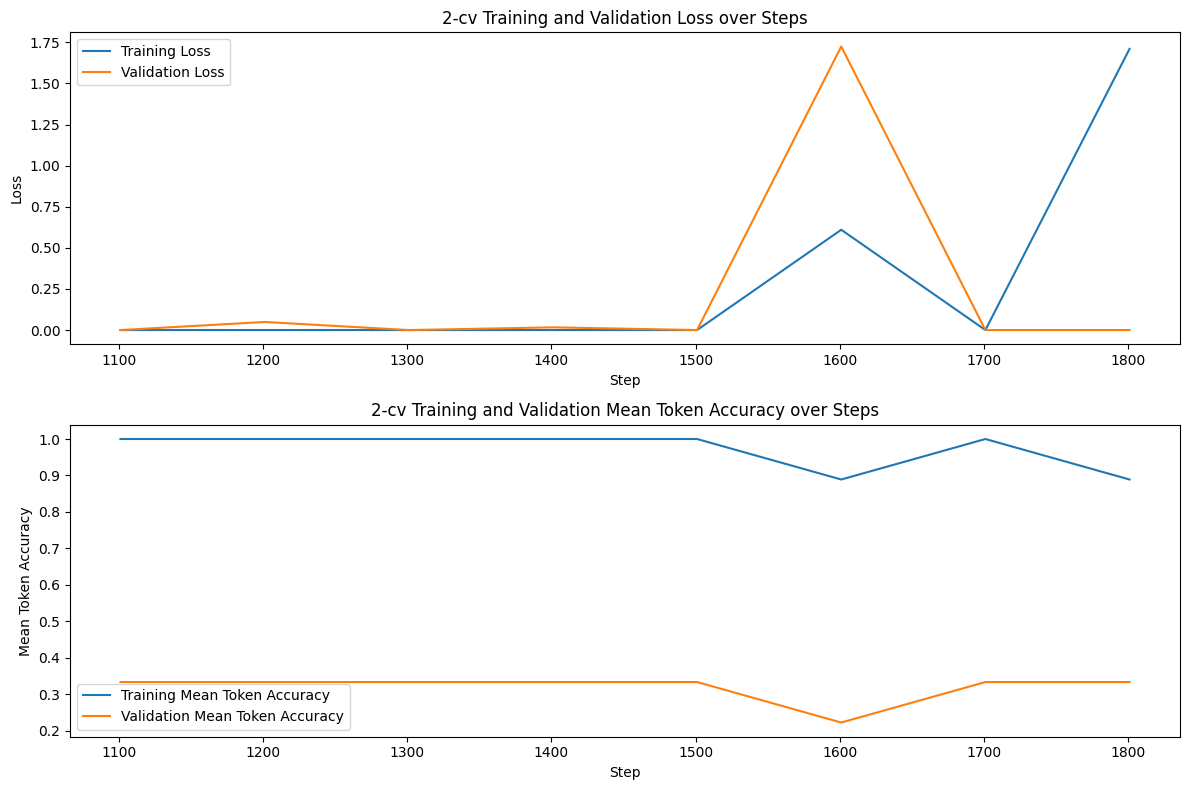

In [39]:
# Extract information from the response
steps, train_losses, valid_losses, train_accs, valid_accs = extract_info_from_response(response_2cv)

# Create a line plot for Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(steps, train_losses, label='Training Loss')
plt.plot(steps, valid_losses, label='Validation Loss')
plt.title('2-cv Training and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Create a line plot for Mean Token Accuracy
plt.subplot(2, 1, 2)
plt.plot(steps, train_accs, label='Training Mean Token Accuracy')
plt.plot(steps, valid_accs, label='Validation Mean Token Accuracy')
plt.title('2-cv Training and Validation Mean Token Accuracy over Steps')
plt.xlabel('Step')
plt.ylabel('Mean Token Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
response_1cv  = openai.FineTuningJob.list_events(id=job_id_1cv, limit=10)
response_1cv

<OpenAIObject list at 0x7867f92d3060> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-tfiFXTmIy3pmaJfRkIS2KPlO",
      "created_at": 1702830917,
      "level": "info",
      "message": "The job has successfully completed",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-GXyzio1kQI421qeZLSl8xJNv",
      "created_at": 1702830914,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:personal::8WoOf5E7",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-XFMCoqE7SPAT7QatejXgS5IF",
      "created_at": 1702830745,
      "level": "info",
      "message": "Step 1801/1875: training loss=0.00, validation loss=0.00",
      "data": {
        "step": 1801,
        "train_loss": 6.35782896551973e-07,
        "valid_loss": 1.0596381293402778e-06,
        "train_mean_tok

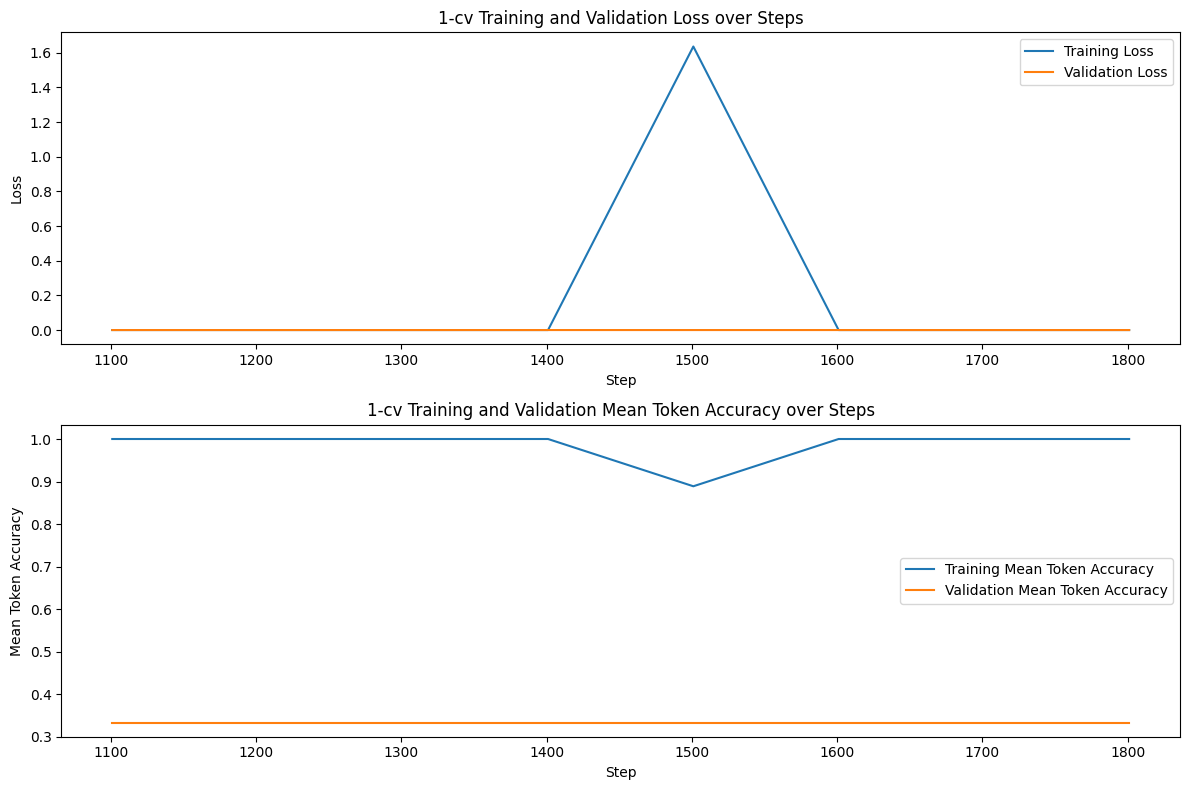

In [41]:
# Extract information from the response
steps, train_losses, valid_losses, train_accs, valid_accs = extract_info_from_response(response_1cv)

# Create a line plot for Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(steps, train_losses, label='Training Loss')
plt.plot(steps, valid_losses, label='Validation Loss')
plt.title('1-cv Training and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Create a line plot for Mean Token Accuracy
plt.subplot(2, 1, 2)
plt.plot(steps, train_accs, label='Training Mean Token Accuracy')
plt.plot(steps, valid_accs, label='Validation Mean Token Accuracy')
plt.title('1-cv Training and Validation Mean Token Accuracy over Steps')
plt.xlabel('Step')
plt.ylabel('Mean Token Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

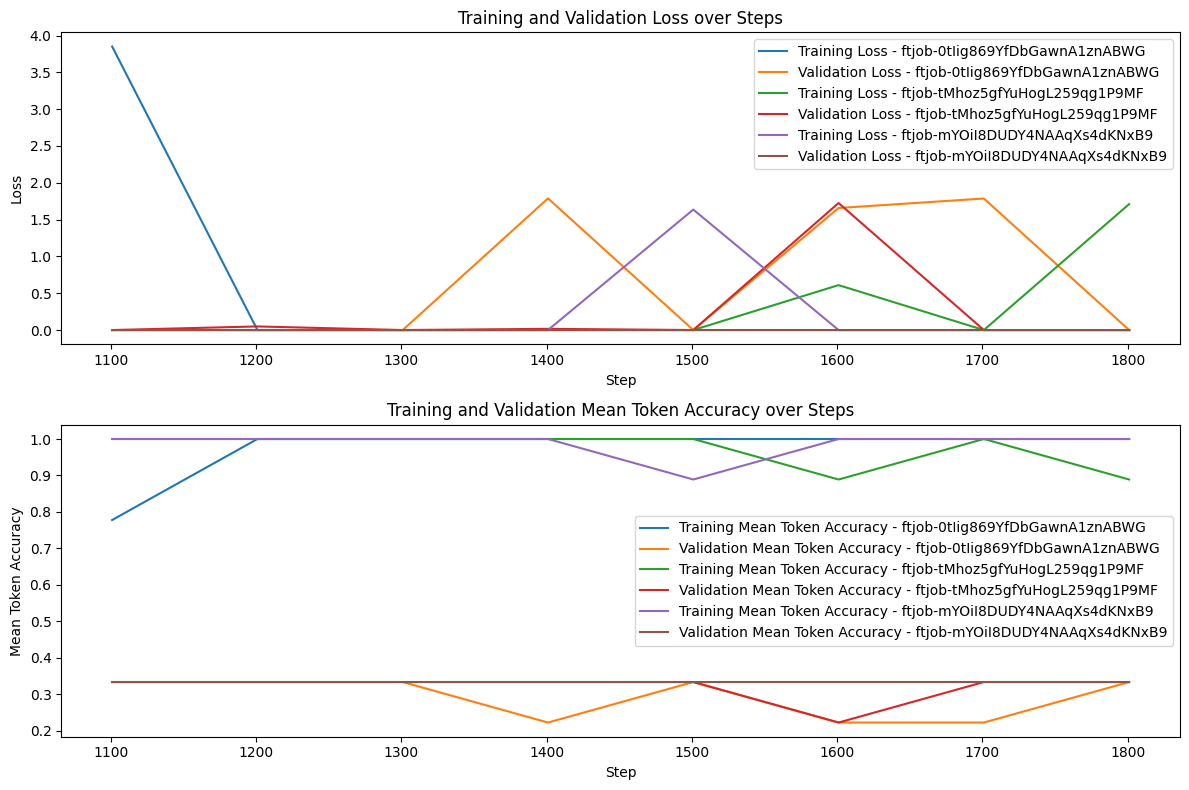

In [43]:
# Assuming response_ids is a list of response IDs
response_ids = [job_id_3cv, job_id_2cv, job_id_1cv]

# Create a line plot for each response
plt.figure(figsize=(12, 8))

for response_id in response_ids:
    # Assuming response is a variable containing the API response
    # For example: response = openai.FineTuningJob.list_events(id=response_id, limit=10)
    response = openai.FineTuningJob.list_events(id=response_id, limit=10)

    # Extract information from the response
    steps, train_losses, valid_losses, train_accs, valid_accs = extract_info_from_response(response)

    # Create a line plot for Loss
    plt.subplot(2, 1, 1)
    plt.plot(steps, train_losses, label=f'Training Loss - {response_id}')
    plt.plot(steps, valid_losses, label=f'Validation Loss - {response_id}')

    # Create a line plot for Mean Token Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(steps, train_accs, label=f'Training Mean Token Accuracy - {response_id}')
    plt.plot(steps, valid_accs, label=f'Validation Mean Token Accuracy - {response_id}')

# Configure plot settings
plt.subplot(2, 1, 1)
plt.title('Training and Validation Loss over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Training and Validation Mean Token Accuracy over Steps')
plt.xlabel('Step')
plt.ylabel('Mean Token Accuracy')
plt.legend()

plt.tight_layout()
plt.show()